In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2
index,,,,,,,,,,
AAACCCACATGGCTGC-1_fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050
AAACCCAGTATATGGA-1_fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433
AAACCCAGTCAACACT-1_fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299
AAACCCATCCCGTGAG-1_fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034
AAACCCATCGAACTCA-1_fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702


In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050,fasted,m
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433,fasted,m
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299,fasted,m
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034,fasted,m
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702,fasted,m


In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

adata

AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts'

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


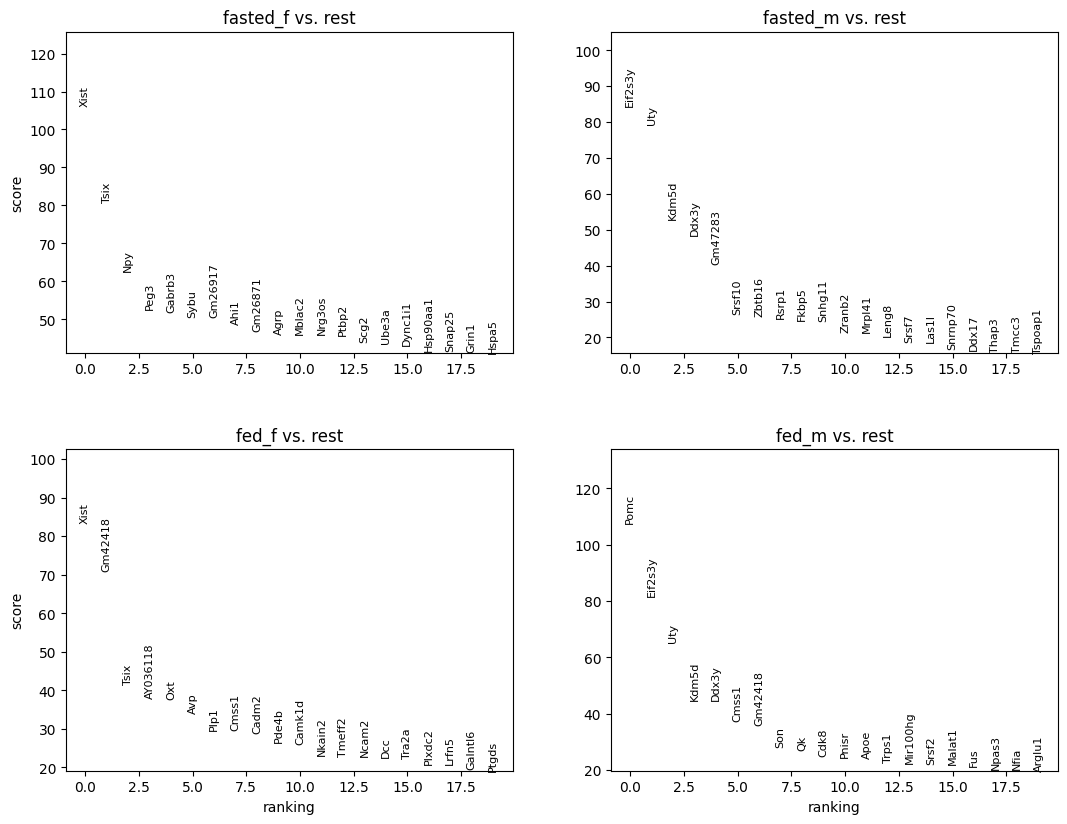

In [6]:
sc.tl.rank_genes_groups(adata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


group='fasted_f' hi_deg.shape=(488, 7)
group='fasted_m' hi_deg.shape=(15, 7)
group='fed_f' hi_deg.shape=(111, 7)
group='fed_m' hi_deg.shape=(170, 7)


Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values


res.shape=(784, 7)


Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Sep 13 14:45:02 2023 WARNING posx and posy should be finite values
Wed Se

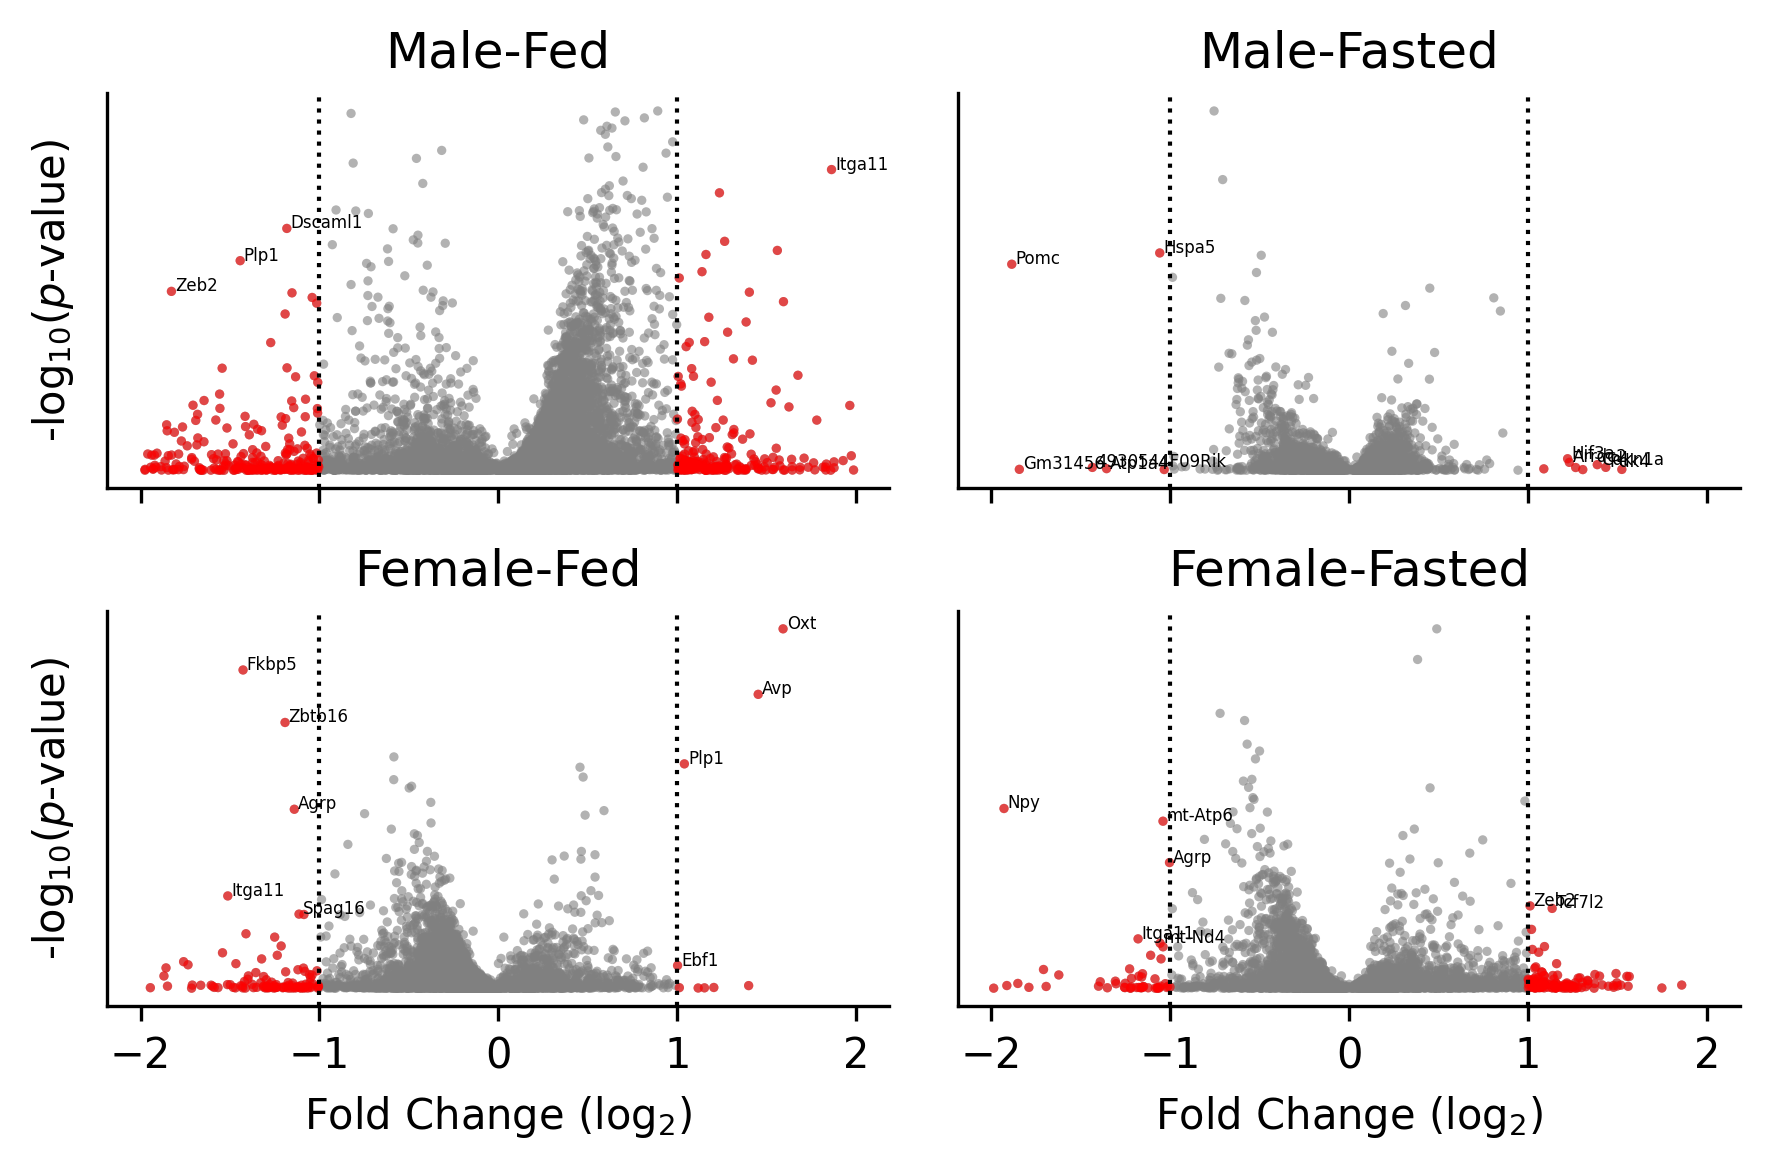

In [115]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')

deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [132]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/all_batch_DEG.csv"
res.to_csv(outpath, index=False)
res.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,log10p
0,fasted_f,Hspa5,33.161758,1.488089,3.833433e-241,8.733257e-238,240.416412
1,fasted_f,Scg2,32.730526,1.048977,5.747592e-235,1.107959e-231,234.240514
2,fasted_f,Agrp,32.587852,1.883084,6.095631e-233,1.091118e-229,232.214981
3,fasted_f,Gm26917,31.599413,1.309527,3.761312e-219,6.283899e-216,218.424661
4,fasted_f,Ghr,24.335096,1.518430,8.337898e-131,6.529616e-128,130.078943


 GLU                  22020
 GABA                 13693
 Oligodendrocytes      3383
 Astrocytes            1674
 OPC                    699
 Immune                 648
 Ependymal              439
 Mural+Endothelial      199
 ParsTuber               93
 Fibroblasts             89
Name: broad_type, dtype: int64


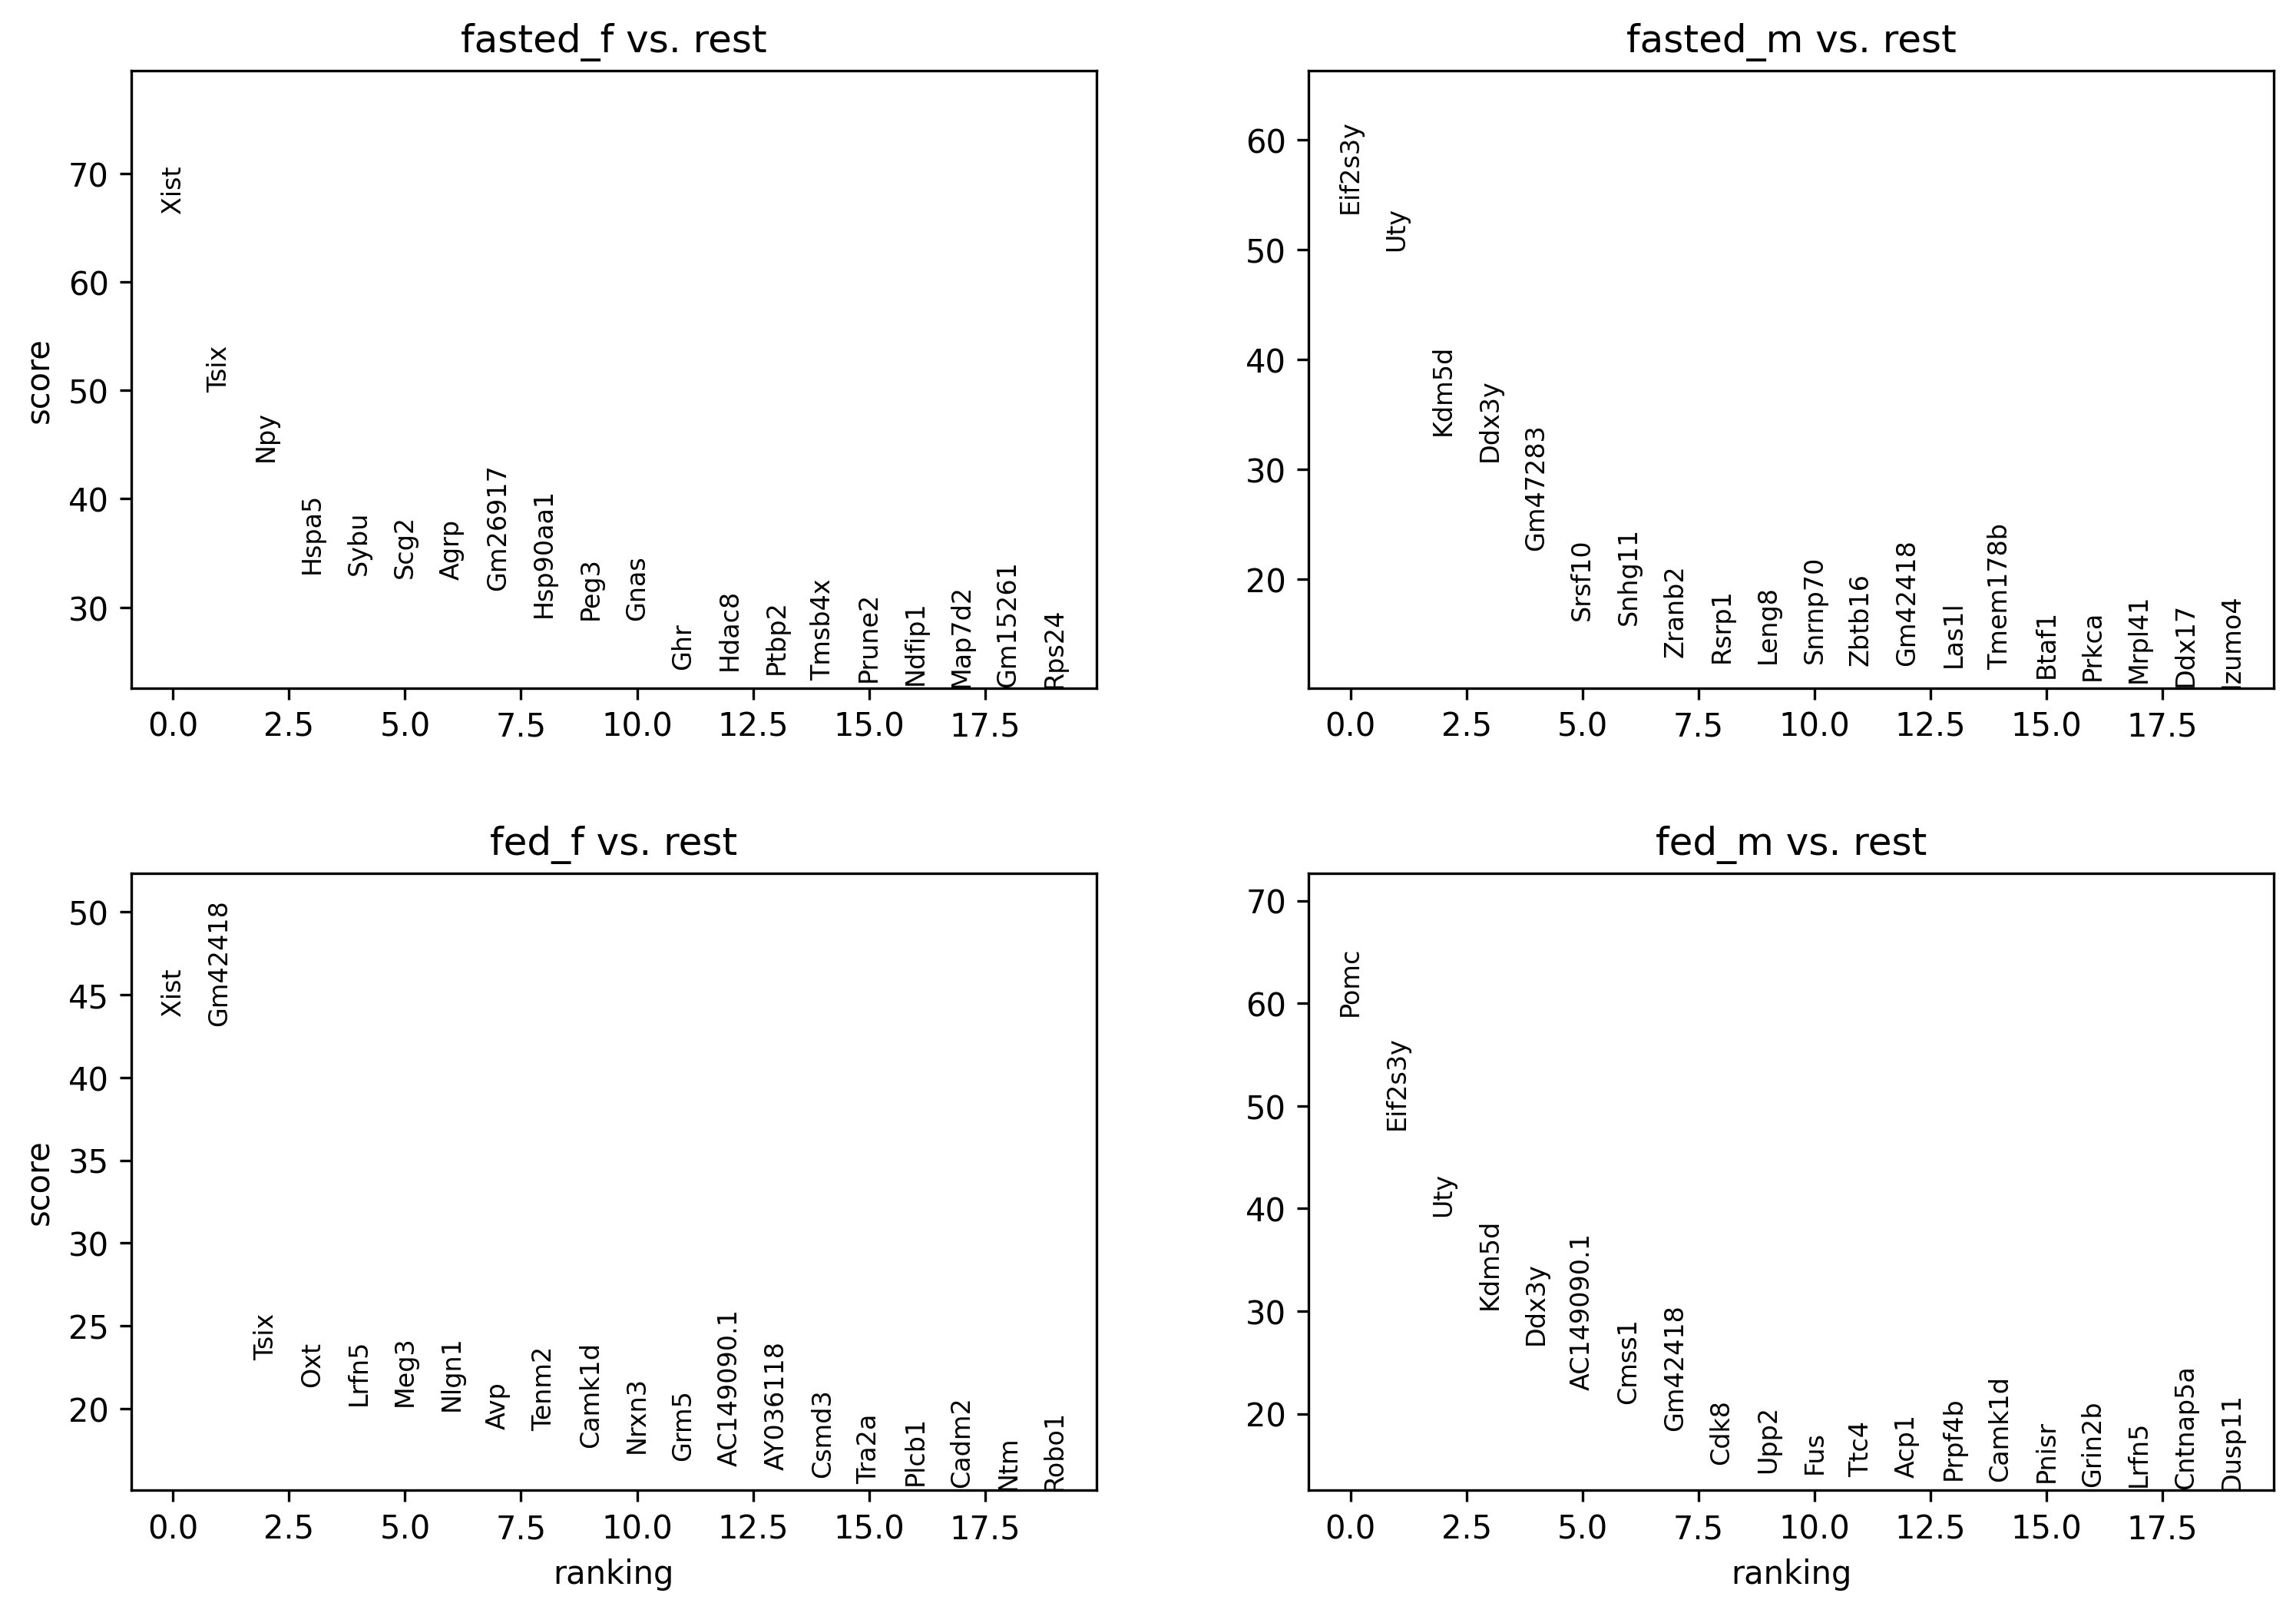

In [130]:
print(adata.obs["broad_type"] .value_counts())

""" Subset the nuerons """
# ctypes = [' GLU', ' GABA']
ctypes = [' GABA']
ndata = adata[adata.obs["broad_type"].isin(ctypes)].copy()

sc.tl.rank_genes_groups(ndata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(ndata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)



deg.shape=(100240, 6)
group='fasted_f' hi_deg.shape=(216, 7)
group='fasted_m' hi_deg.shape=(9, 7)
group='fed_f' hi_deg.shape=(82, 7)
group='fed_m' hi_deg.shape=(41, 7)
res.shape=(348, 7)


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Wed Sep 13 15:04:58 2023 WARNING posx and posy should be finite values
Wed Sep 13 15:04:59 2023 WARNING posx and posy should be finite values
Wed Sep 13 15:04:59 2023 WARNING posx and posy should be finite values
Wed Sep 13 15:04:59 2023 WARNING posx and posy should be finite values
Wed Sep 13 15:04:59 2023 WARNING posx and posy should be finite values
Wed Sep 13 15:04:59 2023 WARNING posx and posy should be finite values


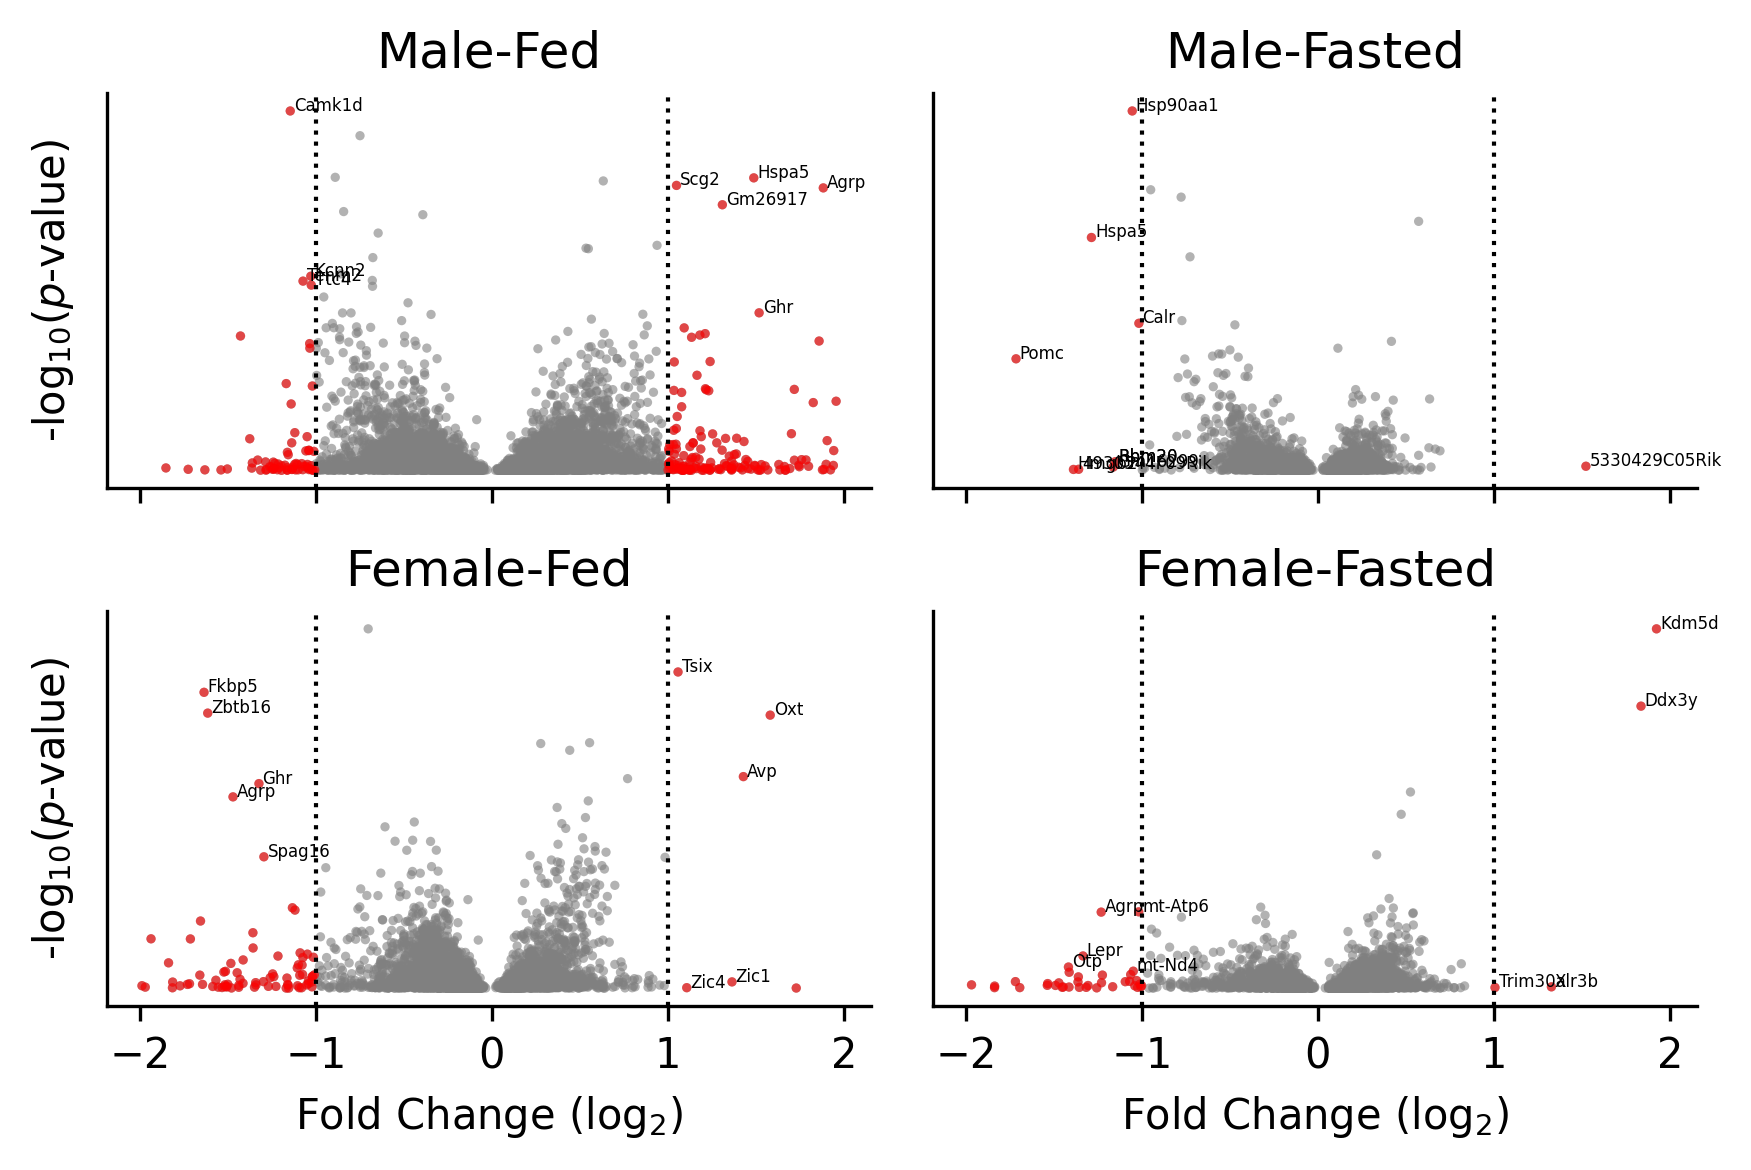

In [131]:
deg = sc.get.rank_genes_groups_df(ndata, 
                                  group=None,
                                  key='pairwise_batch')

print(f"{deg.shape=}")
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

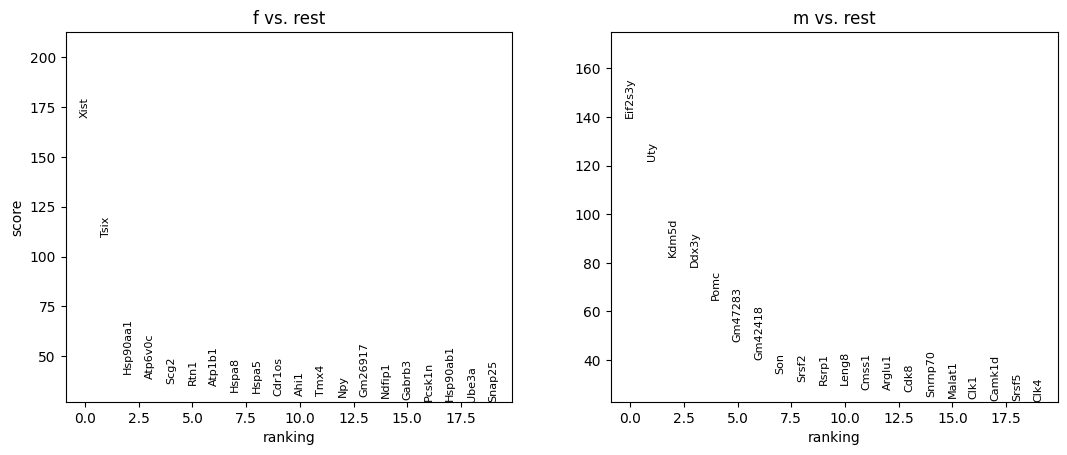

In [8]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Sex', 
                        method='wilcoxon',
                        key_added='sex',
                        corr_method='bonferroni') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='sex',
                        sharey=False)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


hi_deg.shape=(42, 7)


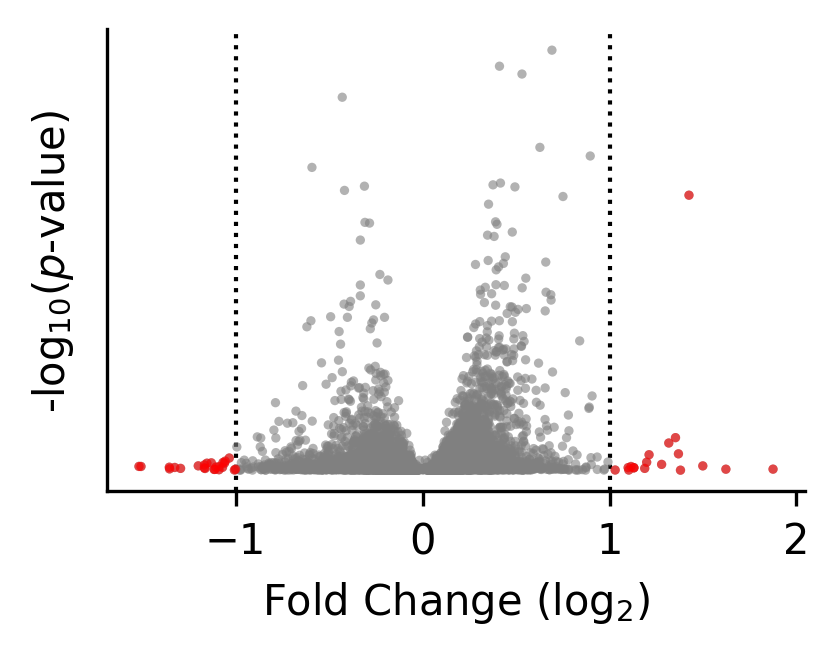

In [65]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')


deg = deg[deg['group'] == 'f'].reset_index(drop=True)
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1

mask =  (deg['logfoldchanges'] > -2) & (deg['logfoldchanges'] < 2) & (deg['pvals'] <= alpha)
deg = deg[mask].reset_index(drop=True)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                s=5)

mask = (deg['logfoldchanges'] < -thresh) | (deg['logfoldchanges'] > thresh)

hi_deg = deg[mask].reset_index(drop=True)
print(f"{hi_deg.shape=}")

sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                s=5)

plt.axvline(x=thresh, lw=1, c='k', ls=':', zorder=0)
plt.axvline(x=-thresh, lw=1, c='k', ls=':', zorder=0)
plt.yticks([], [])
plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
sns.despine()

In [67]:
hi_deg.sort_values(by='logfoldchanges')

,group,names,scores,logfoldchanges,pvals,pvals_adj,log10p
33,f,Pdk4,-3.814090,-1.516886,1.366855e-04,1.000000e+00,3.864277
32,f,Gm42756,-3.800296,-1.505925,1.445233e-04,1.000000e+00,3.840062
29,f,Plin4,-3.490019,-1.354411,4.829858e-04,1.000000e+00,3.316066
23,f,C030005K06Rik,-2.717044,-1.353243,6.586789e-03,1.000000e+00,2.181326
27,f,Itgad,-3.387240,-1.325506,7.059966e-04,1.000000e+00,3.151197
25,f,4933406B17Rik,-2.965285,-1.294342,3.024029e-03,1.000000e+00,2.519414
34,f,Xlr3b,-4.035999,-1.199671,5.437051e-05,1.000000e+00,4.264637
26,f,Lfng,-3.204850,-1.167236,1.351327e-03,1.000000e+00,2.869240
35,f,Gm44866,-4.350428,-1.166568,1.358719e-05,3.404949e-01,4.866870
24,f,Pdzph1,-2.922377,-1.163266,3.473711e-03,1.000000e+00,2.459206


In [ ]:
break

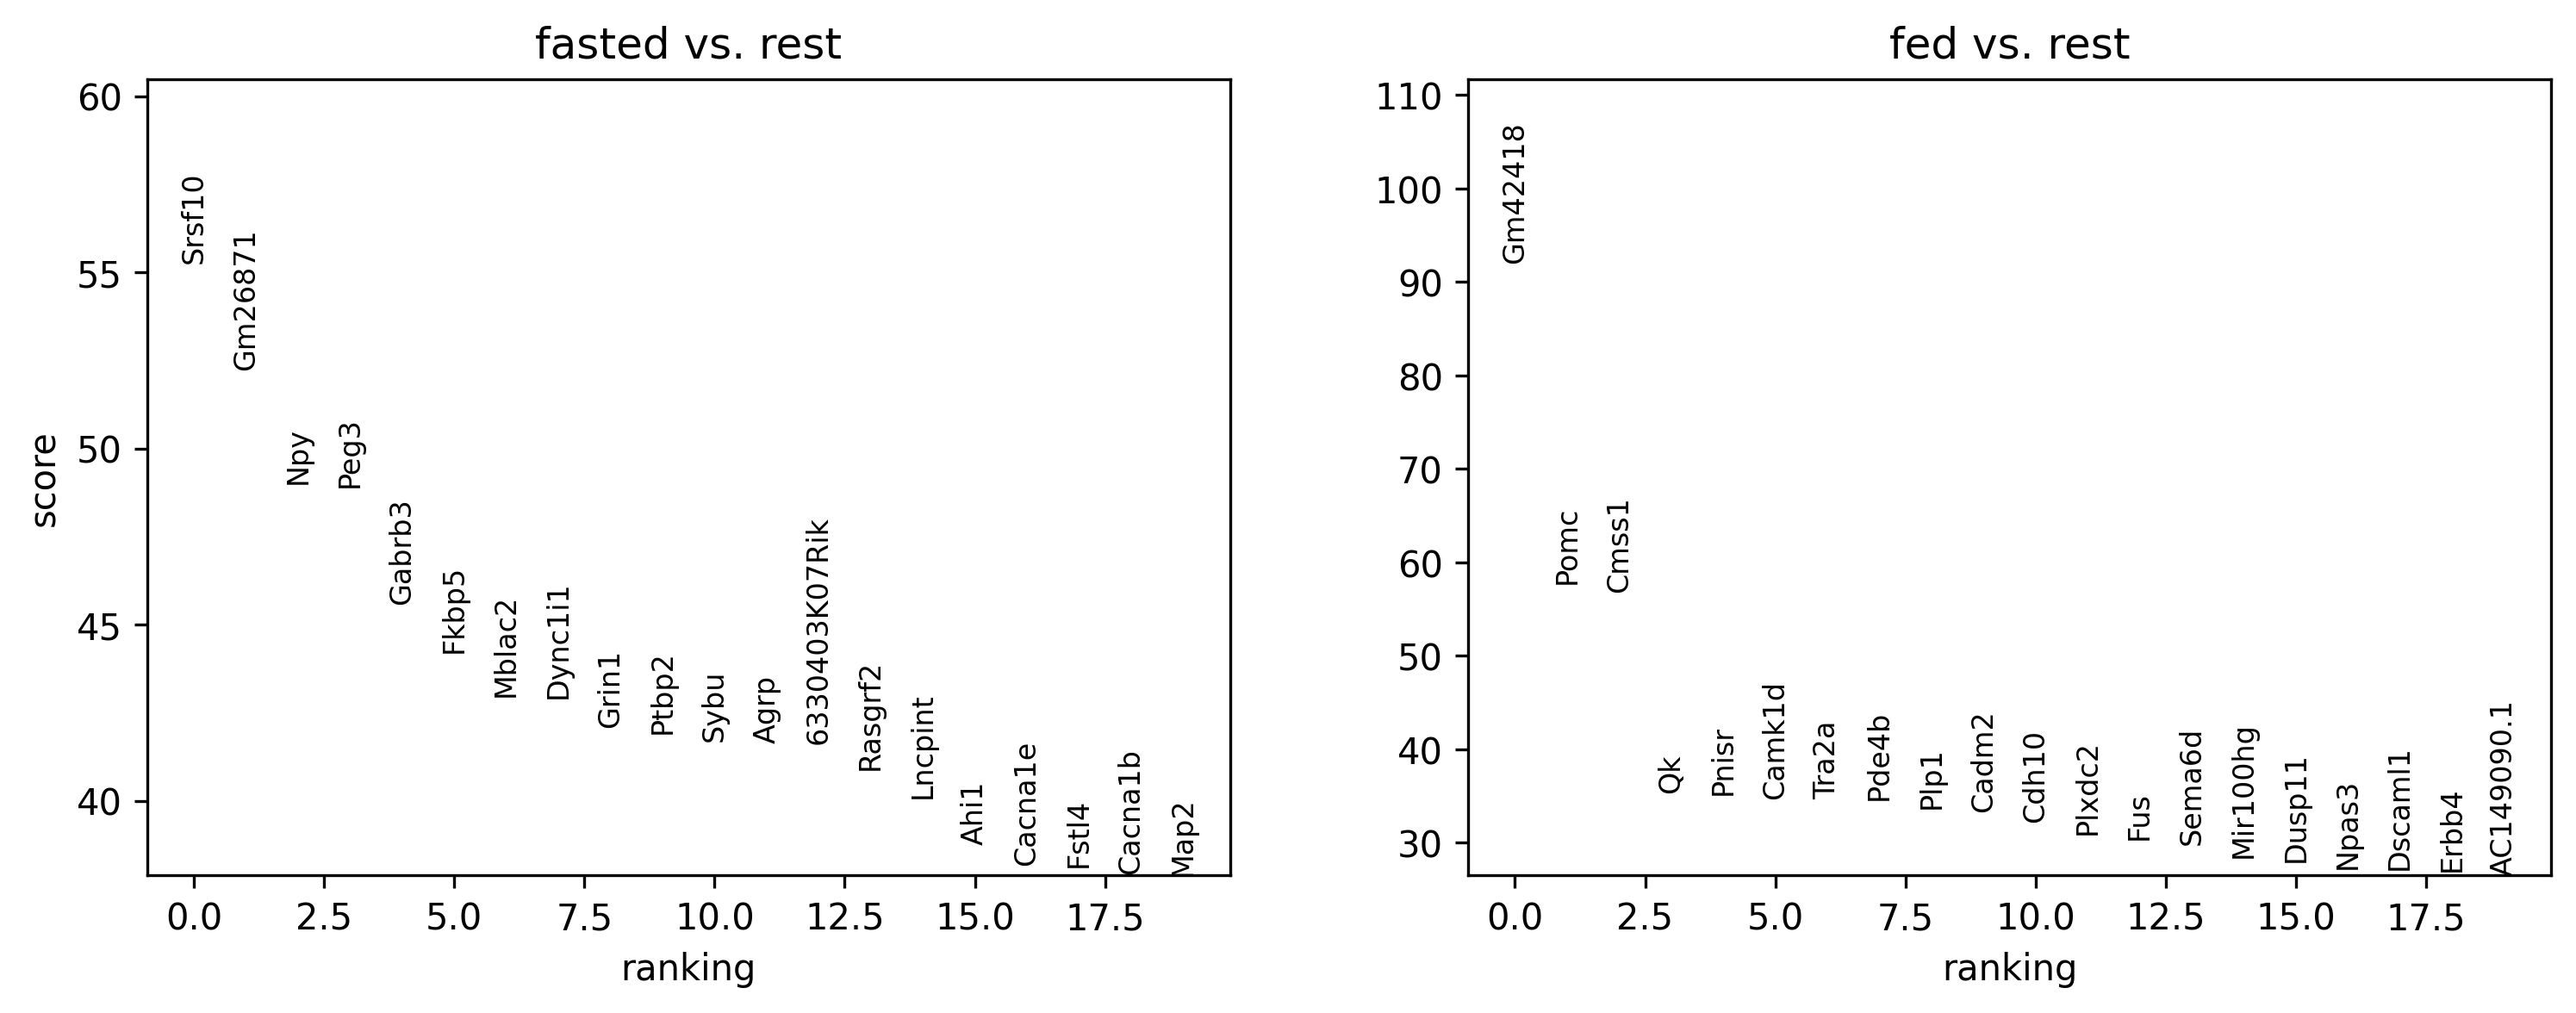

In [105]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Diet', 
                        method='wilcoxon',
                        key_added='diet',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='diet',
                        sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='broad_type', 
                        method='wilcoxon',
                        key_added='broad_type',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='broad_type',
                        sharey=False,
                        ncols=3)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='reference_embedding_C25_named_clean', 
                        method='wilcoxon',
                        key_added='subtype',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='subtype',
                        sharey=False,
                        ncols=3)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='sex')

deg.head()

In [ ]:
# NOW for some exploration of Mc3r+ cells